In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt

etfs = ['SPY', 'TLT', '^IXIC']
years = 20
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)
returns = yf.download(etfs, start=startDate, end=endDate)['Adj Close']

[*********************100%%**********************]  3 of 3 completed


In [25]:
log_returns = np.log(returns / returns.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

Ticker           SPY       TLT     ^IXIC
Date                                    
2004-11-30  0.000679 -0.004247 -0.004786
2004-12-01  0.011302 -0.001560  0.019561
2004-12-02  0.000839 -0.004056  0.002494
2004-12-03 -0.000671  0.015443  0.002046
2004-12-06 -0.000336  0.003425  0.001531
...              ...       ...       ...
2024-11-15 -0.012891 -0.002661 -0.022629
2024-11-18  0.004089  0.001775  0.005961
2024-11-19  0.003649  0.005085  0.010358
2024-11-20  0.000339 -0.003202 -0.001124
2024-11-21  0.005354 -0.000775  0.000331

[5030 rows x 3 columns]


In [26]:
weights = np.array([0.6,0.2,0.2])
historical_returns = (log_returns * weights).sum(axis =1)

# Calculate the average of the historical returns
average_log_return = historical_returns.mean()

# Annualize the log return (multiply by the number of trading days in a year)
annualized_log_return = average_log_return * 365

# Convert the annualized log return to an arithmetic return (since it's compounded)
annualized_return = np.exp(annualized_log_return) - 1

# Print the result
print(f'Annualized Weighted Return (with compounding, without inflation): {annualized_return:.4f}')


Annualized Weighted Return (with compounding, without inflation): 0.1371


In [27]:
days = 365

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()

In [28]:
# Calculate the standard deviation of the log returns (historical_returns)
returns_std = range_returns.std()

print(f'Portfolio {days} days Standard Deviation: {returns_std:.4f}')


Portfolio 365 days Standard Deviation: 0.1586


In [29]:

# Calculate Sharpe Ratio (assuming risk-free rate of 0.0439 for example)
risk_free_rate = 0.0439  # You could also fetch this dynamically
sharpe_ratio = (annualized_return - risk_free_rate) / returns_std
print(f'Portfolio Sharpe Ratio: {sharpe_ratio:.4f}')

Portfolio Sharpe Ratio: 0.5875


In [30]:
# ... after historical returns calculation ...

def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = cumulative / rolling_max - 1
    return drawdowns.min()

max_drawdown = calculate_max_drawdown(historical_returns)
print(f'Maximum Drawdown: {max_drawdown:.4%}')


Maximum Drawdown: -48.0410%


In [35]:
correlation_matrix = log_returns.corr()
# ... after weights calculation ...

def calculate_diversification_score(weights, correlation_matrix):
    # Calculate concentration
    concentration = np.sum(weights ** 2)
    
    # Calculate portfolio correlation
    weighted_correlation = np.dot(np.dot(weights, correlation_matrix), weights)
    
    # Calculate diversification score (1 = poorly diversified, N = perfectly diversified)
    div_score = 1 / (concentration * weighted_correlation)
    
    # Calculate maximum possible score (number of assets)
    max_score = len(weights)
    
    # Calculate as a percentage of maximum possible diversification
    div_percentage = (div_score / max_score) * 100
    
    return div_score, div_percentage

div_score, div_percentage = calculate_diversification_score(weights, correlation_matrix)
print(f"\nDiversification Analysis:")
print(f"Diversification Score: {div_score:.2f}")
print("Interpretation:")
if div_score > len(weights):
    print("✓ Excellent diversification! Your assets have beneficial negative correlations.")
    print("  This means they tend to move in opposite directions, reducing portfolio risk.")
elif div_score > len(weights) * 0.7:
    print("✓ Good diversification. Your assets have low correlations with each other.")
else:
    print("! Consider adding more diversification. Your assets may be too correlated.")


Diversification Analysis:
Diversification Score: 4.02
Interpretation:
✓ Excellent diversification! Your assets have beneficial negative correlations.
  This means they tend to move in opposite directions, reducing portfolio risk.


In [32]:
confidence_interval = 0.95

VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100))
cvar = -range_returns[range_returns <= -VaR].mean()

# Output the results
print(f"VaR: There is a {(1-confidence_interval)*100:.2f}% chance that the portfolio loss will exceed {VaR*100:.2f}% in {days} days.")
print(f"CVaR: If the loss exceeds the VaR, the average loss is {cvar*100:.2f}% in {days} days.")

VaR: There is a 5.00% chance that the portfolio loss will exceed 18.63% in 365 days.
CVaR: If the loss exceeds the VaR, the average loss is 33.36% in 365 days.


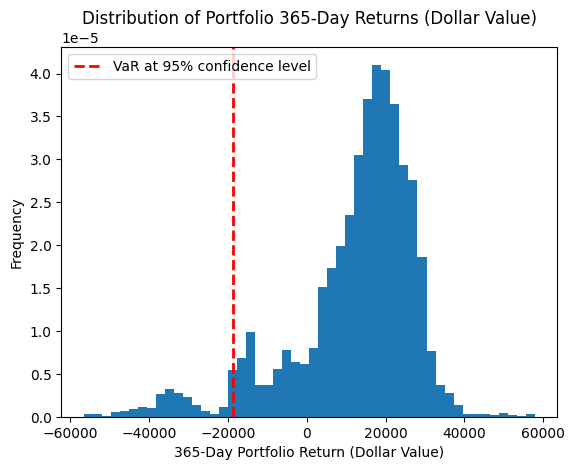

In [33]:
return_window = days
range_returns = historical_returns.rolling(window=return_window).sum()
range_returns = range_returns.dropna()
portfolio_value = 100000
range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=50, density=True)
plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.axvline(-VaR*portfolio_value, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()